# 05_WindForcing

Relation to large-scale patterns of atm. forcing

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
# from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.ticker as mticker

from scipy import stats


# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_NSIDC.icedrift as icedrift
import data_UniBremen.SIC as unisic

In [492]:
plt.style.use('../jgr_oceans.mplstyle')

def SAVE(fig, filename):
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.05)

    

In [35]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

## Reference grids

In [36]:


# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))


In [37]:
df = pd.read_csv('../data/compiled_stats.csv')

df['esei'] = vectors.comp_along_theta(df['ui'], df['vi'], 145*units('degree')) * units('cm/s').to('km/day')
df['ese10'] = 0.02*vectors.comp_along_theta(df['u10'], df['v10'], 180*units('degree'))* units('m/s').to('km/day')
# df['ese10'][df.year>=2016] = 1.3*df['ese10'][df.year>=2016]




df['si_km'] = df['si'] * units('cm/s').to('km/day')

df['e10'] = - df['u10']
# manually modify this for now since I set too strict of threshold

for cat in ['a10', 'ai', 'centermass_direction', 'max_length_direction']:
    df[f'{cat}_r'] = 90-df[f'{cat}']
    df[f'{cat}_r'][df[f'{cat}_r']<0]+=360

df['up'] = df['centermass_length'].values * np.cos(df['centermass_direction'].values*np.pi/180)
df['vp'] = df['centermass_length'].values * np.sin(df['centermass_direction'].values*np.pi/180)
                     
    
vi = (df['ui'].values, df['vi'].values)
vw = (df['u10'].values, df['v10'].values)
vp = (df['up'].values, df['vp'].values )
                              
df['ta_wi'] = vectors.turning_angle(vw,vi).magnitude
df['ta_ip'] = vectors.turning_angle(vi,vp).magnitude
df['ta_wp'] = vectors.turning_angle(vw,vp).magnitude




# identify base period
dfb = df[df['2003_2023']]

dfr = df[df.year >= 2003]



/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_59413/810645748.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_59413/810645748.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_59413/810645748.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [408]:


years = np.arange(2003,2026)
doys = np.arange(-92,182)

all_extents = np.array([])
all_doys = np.array([])

year = 2025
ti = datetime(year, 1, 1) + timedelta(days=int(doys[0]))
tf2 = datetime(year, 1, 1) + timedelta(days=int(doys[-1]))
print(ti,tf2)

for year in years:
    
#     if year == 2025:    
#         with xr.open_dataset(f'../data/polynya_size/daily_polynya_2025_sic10_v7.6_radius25km.nc') as ds:

#             print(ds.time)
#             ti = datetime(year, 1, 1) + timedelta(days=int(doys[0]))
#             tf2 = datetime(year, 1, 1) + timedelta(days=int(doys[-1]-1))
#             ds = ds.sel(time=slice(ti,tf2))
#             print(ti, tf2)

#             # save times and areas
#             dt = (pd.to_datetime(ds.time.values) - datetime(year, 1, 1)).days
#             areas = ds.polynya_extent + ds.other_polynya_extent
            
# #             areas = np.concatenate((np.full(31,100000), areas.values))
            
# #             areas = np.concatenate((areas, np.full(273-len(areas), np.nan)))
# #             print(areas)
#             curr_areas = areas

#             curr_doy = np.append(curr_doy, dt)
        
#                     # crop time
#             ti = datetime(year, 1, 1) + timedelta(days=int(doys[0]))
#             tf = datetime(year, 1, 1) + timedelta(days=int(134))
#             ds = ds.sel(time=slice(ti,tf))

#     #         print(len(ds.time), tf)

#             # save times and areas
#             dt = (pd.to_datetime(ds.time.values) - datetime(year, 1, 1)).days
#             areas = ds.polynya_extent + ds.other_polynya_extent

#             curr_areas = areas
#             curr_doy = dt


        
#     else:    
    with xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.6_radius25km.nc') as ds:
#     with xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.4_radius25km.nc') as ds:

        # crop time
        ti = datetime(year, 1, 1) + timedelta(days=int(doys[0]))
        tf = datetime(year, 1, 1) + timedelta(days=int(doys[-1]))#134))
        ds = ds.sel(time=slice(ti,tf))

#         print(len(ds.time), tf)

        # save times and areas
        dt = (pd.to_datetime(ds.time.values) - datetime(year, 1, 1)).days
        areas = np.copy(ds.polynya_extent.values) + ds.other_polynya_extent

        
        areas_interp, _ = tseries.linear_interpolate(pd.to_datetime(ds.time.values), 
                                                      pd.to_datetime(ds.time.values), 
                                                      areas, max_dt = 7 * units('day'))
        
        
        curr_areas = areas_interp
        curr_doy = dt


#         with xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.6_radius25km.nc') as ds:

#             tf2 = datetime(year, 1, 1) + timedelta(days=int(doys[-1]-1))
#             ds = ds.sel(time=slice(tf,tf2))
#     #         print(len(ds.time), tf2)

#             # save times and areas
#             dt = (pd.to_datetime(ds.time.values) - datetime(year, 1, 1)).days
#             areas = ds.polynya_extent + ds.other_polynya_extent

#             curr_areas = np.append(curr_areas, areas)

#             curr_doy = np.append(curr_doy, dt)

#     print(len(curr_doy))

    all_extents = np.append(all_extents, curr_areas)
    all_doys = np.append(all_doys, curr_doy)

extents = np.reshape(all_extents, (len(years), len(doys)))

#     all_extents = np.append(all_extents, df[df.year == year].extent.values)

2024-10-01 00:00:00 2025-07-01 00:00:00


In [409]:
# tO = (datetime(year-1, 10, 1) - datetime(year, 1, 1)).days
# tN = (datetime(year-1, 11, 1) - datetime(year, 1, 1)).days
# tD = (datetime(year-1, 12, 1) - datetime(year, 1, 1)).days
# tJ = (datetime(year, 1, 1) - datetime(year, 1, 1)).days
# tF = (datetime(year, 2, 1) - datetime(year, 1, 1)).days
# tM = (datetime(year, 3, 1) - datetime(year, 1, 1)).days
# tA = (datetime(year, 4, 1) - datetime(year, 1, 1)).days

# tMa = (datetime(year, 5, 1) - datetime(year, 1, 1)).days
# tJu = (datetime(year, 6, 1) - datetime(year, 1, 1)).days
# tJl = (datetime(year, 7, 1) - datetime(year, 1, 1)).days


tO = datetime(year-1, 10, 1) 
tN = datetime(year-1, 11, 1) 
tD = datetime(year-1, 12, 1) 
tJ = datetime(year, 1, 1) 
tF = datetime(year, 2, 1) 
tM = datetime(year, 3, 1) 
tA = datetime(year, 4, 1) 

tMa = datetime(year, 5, 1) 
tJu = datetime(year, 6, 1) 
tJl = datetime(year, 7, 1) 



<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_59413/1997074334.py:40: SyntaxWarning: invalid escape sequence '\m'
  cb_label='Open extent $\mathrm{(km^2)}$', labelpad='auto',


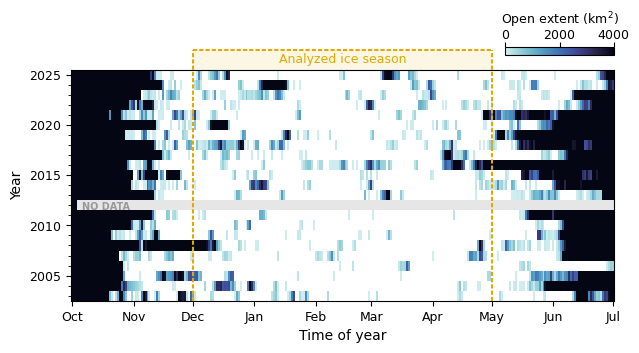

In [410]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib import ticker
from matplotlib.colors import ListedColormap
import cmocean
from matplotlib.ticker import FixedLocator

# --- Setup figure and axis ---
fig, ax = plt.subplots(figsize=(7, 3))
ax.set_facecolor([0.9, 0.9, 0.9])

# --- Modify colormap ---
cmap = cmocean.tools.crop_by_percent(cmocean.cm.ice_r, 5, which='min')
colors = cmap(np.arange(cmap.N))
colors[0] = [1, 1, 1, 1]  # Replace first color with white
modified_cmap = ListedColormap(colors)

# --- Pcolormesh plot ---
mesh = ax.pcolormesh(ds.time, years, extents, vmin=0, vmax=4000, cmap=modified_cmap)

# --- Customize x-axis ---
# Set major ticks to the first day of each month
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # 'Jan', 'Feb', etc.
ax.set_xlabel('Time of year')

# --- Customize y-axis ---
ax.set_ylabel('Year')
ax.set_ylim(years.min() - 0.5, years.max() + 0.5)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

# --- Colorbar ---
plotter.add_colorbar(
    fig, ax, [mesh],
    cb_placement='top', cb_orientation='auto',
    cb_width=0.025, cb_length_fraction=[0.8, 1], cb_pad=0.05,
    cb_ticks='auto', cb_ticklabels='auto', cb_extend='neither',
    cb_label='Open extent $\mathrm{(km^2)}$', labelpad='auto',
    cb_label_placement='auto', cb_tick_placement='auto',
    tick_kwargs = {'pad':0.1}, cb_labelsize=plt.rcParams['font.size'],
    draw_edges=False, edge_params=['k', 2]
)

# --- Ice season highlight rectangle ---
top_y = years.max() + 0.5
height = 2
is_color = [226/255, 170/255, 0/255]

rect = Rectangle(
    (tD, top_y), tMa - tD, height,
    facecolor=is_color, edgecolor='None',
    alpha=0.1, linewidth=1.25, clip_on=False
)
ax.add_patch(rect)

# --- Labels and annotations ---
ax.text(tO +timedelta(days=5), 2012-0.1, 'NO DATA', ha='left', va='center', c=[0.6]*3,weight='bold', size=plt.rcParams['font.size']-2)
ax.text(0.5, 1.045, 'Analyzed ice season', transform=ax.transAxes,
        ha='center', va='center', c=is_color, )

# --- Draw bounding lines around ice season ---
line_kwargs = dict(color=is_color, lw=1.5, linestyle='solid', clip_on=False, zorder=100)
dashed_kwargs = {**line_kwargs, 'dashes': (2, 1)}

ax.plot([tD, tD], [2003 - 0.5, top_y + height], **dashed_kwargs)
ax.plot([tMa, tMa], [2003 - 0.5, top_y + height], **dashed_kwargs)
ax.plot([tD, tMa], [top_y + height, top_y + height], **dashed_kwargs)

# ax.tick_params(axis='x', which='minor', length=4, color='gray', )
# ax.tick_params(axis='x', which='major', length=7, color='black', width=1.5)

SAVE(fig, '../figures/results/occurrences/Fig02b.png')

<>:51: SyntaxWarning: invalid escape sequence '\m'
<>:128: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\m'
<>:128: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_59413/418287615.py:51: SyntaxWarning: invalid escape sequence '\m'
  cb_label='Open water extent $\mathrm{(km^2)}$', labelpad='auto',
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_59413/418287615.py:128: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Maximum\nextent $\mathrm{(km^2)}$')


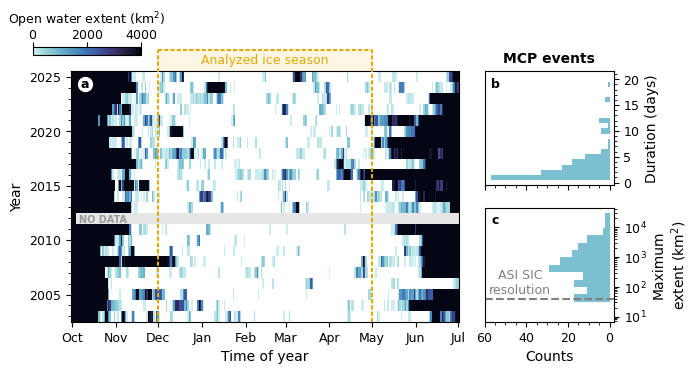

In [527]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from matplotlib import ticker
import cmocean

# === Dummy placeholders (replace with real data) ===
# Assume doys is 1D array of time-of-year values
# Assume years is 1D array of years
# Assume extents is a 2D array of shape (len(years), len(doys))
# Assume tO, tN, tD, ... etc. are defined
# Assume plotter.add_colorbar is a custom colorbar utility

# === Setup figure and layout ===
fig = plt.figure(figsize=(7, 3.25))  # Wider figure to accommodate side panels
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1,1], wspace=0.1, hspace=0.2)

# --- Left Main Panel: pcolormesh plot ---
ax_main = fig.add_subplot(gs[:, 0])  # Span both rows
ax_main.set_facecolor([0.9, 0.9, 0.9])

# --- Modify colormap ---
cmap = cmocean.tools.crop_by_percent(cmocean.cm.ice_r, 5, which='min')
colors = cmap(np.arange(cmap.N))
colors[0] = [1, 1, 1, 1]  # Replace first color with white
modified_cmap = ListedColormap(colors)

# --- Pcolormesh plot ---
mesh = ax_main.pcolormesh(ds.time, years, extents, vmin=0, vmax=4000, cmap=modified_cmap)

# --- Customize x-axis ---
# Set major ticks to the first day of each month
ax_main.xaxis.set_major_locator(mdates.MonthLocator())
ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # 'Jan', 'Feb', etc.
ax_main.set_xlabel('Time of year')

# --- Customize y-axis ---
ax_main.set_ylabel('Year')
ax_main.set_ylim(years.min() - 0.5, years.max() + 0.5)
ax_main.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax_main.yaxis.set_minor_locator(ticker.MultipleLocator(1))

# --- Colorbar ---
plotter.add_colorbar(
    fig, ax_main, [mesh],
    cb_placement='top', cb_orientation='auto',
    cb_width=0.025, cb_length_fraction=[-0.1,0.18], cb_pad=0.05,
    cb_ticks='auto', cb_ticklabels='auto', cb_extend='neither',
    cb_label='Open water extent $\mathrm{(km^2)}$', labelpad='auto',
    cb_label_placement='auto', cb_tick_placement='auto',
    tick_kwargs = {'pad':0.1}, cb_labelsize=plt.rcParams['font.size'],
    draw_edges=False, edge_params=['k', 2]
)

# --- Ice season highlight rectangle ---
top_y = years.max() + 0.5
height = 2
is_color = [226/255, 170/255, 0/255]

rect = Rectangle(
    (tD, top_y), tMa - tD, height,
    facecolor=is_color, edgecolor='None',
    alpha=0.1, linewidth=1.25, clip_on=False
)
ax_main.add_patch(rect)

# --- Labels and annotations ---
ax_main.text(tO +timedelta(days=5), 2012-0.1, 'NO DATA', ha='left', va='center', c=[0.6]*3,weight='bold', size=plt.rcParams['font.size']-2)
ax_main.text(0.5, 1.045, 'Analyzed ice season', transform=ax_main.transAxes,
        ha='center', va='center', c=is_color, )

# --- Draw bounding lines around ice season ---
line_kwargs = dict(color=is_color, lw=1.5, linestyle='solid', clip_on=False, zorder=100)
dashed_kwargs = {**line_kwargs, 'dashes': (2, 1)}

ax_main.plot([tD, tD], [2003 - 0.5, top_y + height], **dashed_kwargs)
ax_main.plot([tMa, tMa], [2003 - 0.5, top_y + height], **dashed_kwargs)
ax_main.plot([tD, tMa], [top_y + height, top_y + height], **dashed_kwargs)

ax_main.scatter(0.035, 0.95,  c='white', s=100,  transform=ax_main.transAxes)
ax_main.text(0.025, 0.975, 'a', weight='bold', ha='left', va='top', transform=ax_main.transAxes)


# --- Right Upper Panel: Metric A ---
ax2 = fig.add_subplot(gs[0, 1], )

ax = ax2

# ax2.plot(time_data, metric_a, color='blue', lw=1)
ax.set_ylabel('Duration (days)')
ax.hist(event_durations, bins=np.arange(0.5,21,1), orientation='horizontal',
        facecolor=cmocean.cm.ice(0.75), edgecolor='None')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xlim(-2,60)
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_xticklabels([])
ax.invert_xaxis()

ax.set_title('MCP events', weight='bold')

ax.text(0.05, 0.95, 'b', weight='bold', ha='left', va='top', transform=ax.transAxes)

# plt.setp(ax2.get_xticklabels(), visible=False)  # Hide x labels

# --- Right Lower Panel: Metric B ---
ax3 = fig.add_subplot(gs[1, 1], )

ax = ax3

# dfr.extent[dfr.sequence!=-999]
ax.hist(max_sizes, bins=np.logspace(1, np.log10(30000), 15), orientation='horizontal', 
        facecolor=cmocean.cm.ice(0.75), edgecolor='None')
ax.semilogy()
ax.axhline(39, c='gray', lw=1.5, ls='dashed')
ax.text(43,45, 'ASI SIC\nresolution', c='gray', ha='center', va='bottom')
ax.set_xlim(-2,60)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))

ax.set_ylabel('Maximum\nextent $\mathrm{(km^2)}$')
ax.set_xlabel('Counts')
ax.invert_xaxis()

# Optional: fine-tune layout
# plt.tight_layout()

ax.text(0.05, 0.95, 'c', weight='bold', ha='left', va='top', transform=ax.transAxes)

SAVE(fig, '../figures/results/occurrences/Fig02b.png')

In [255]:
dfr.keys()

Index(['time', 'month', 'year', 'pre_2003', '2003_2023', 'compact', 'open',
       'q1', 'q2', 'q3', 'q4', 'extent', 'length_145max', 'length_145min',
       'length_145p95', 'length_145p5', 'length_max', 'centermass_length',
       'centermass_direction', 'max_length_direction', 'width595', 'width',
       'ai', 'si', 'ui', 'vi', 'a10', 's10', 'u10', 'v10', 't2m', 'msl',
       'year_start', 'year_end', 'missing_sic', 'sequence', 'event_day',
       'day_before_event', 'day_after_event', 'overlap_flag', 'single_day',
       'season_start_flag', 'season_end_flag', 'first_day', 'final_day',
       'peak_day', 'event_length', 'after_event_length', 'before_event_length',
       'esei', 'ese10', 'si_km', 'e10', 'a10_r', 'ai_r',
       'centermass_direction_r', 'max_length_direction_r', 'up', 'vp', 'ta_wi',
       'ta_ip', 'ta_wp'],
      dtype='object')

In [292]:
event_durations = np.array([])
event_sizes = np.array([])
max_sizes = np.array([])

start_flag = np.array([])
final_flag = np.array([])


all_seqs = np.array(list(set(dfr.sequence[(dfr.sequence!=-999)])))
for ss in all_seqs:
    
    dur = dfr[dfr.sequence==ss].event_length.values.max()
    event_durations = np.append(event_durations, dur)
    

    event_sizes = np.append(event_sizes, np.sum(dfr[dfr.sequence==ss].extent))

#     event_sizes = np.append(event_sizes, np.mean(dfr[dfr.sequence==ss].extent))
    max_sizes = np.append(max_sizes, np.max(dfr[dfr.sequence==ss].extent))
    
    
    start_flag = np.append(start_flag, dfr.season_start_flag[dfr.sequence==ss].values[-1])
    final_flag = np.append(final_flag, dfr.season_end_flag[dfr.sequence==ss].values[-1])
        

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_59413/1477532890.py:53: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,30000)


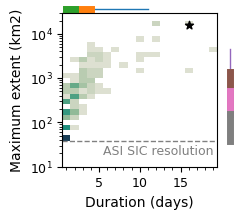

In [401]:
fig, ax = plt.subplots(figsize=(2,2))


# ax.scatter(event_durations, max_sizes, s=30, facecolor='None', edgecolor='k', )

# plt.semilogy()

x = event_durations
y = max_sizes

# Define bins
x_bins = np.arange(0.5, 20.5, 1)       # 29 bins for x
y_bins = np.logspace(1, np.log10(y.max()), 30)#np.linspace(0, 27000, 50)       # 49 bins for y

# Modify colormap
cmap = cmocean.tools.crop_by_percent(cmocean.cm.tempo, 5, which='min')
colors = cmap(np.arange(cmap.N))
colors[0] = [1, 1, 1, 1]
modified_cmap = ListedColormap(colors)


# 2D histogram
out = plt.hist2d(x,#[(start_flag==False)&(final_flag==False)], 
                 y,#[(start_flag==False)&(final_flag==False)], 
                 bins=[x_bins, y_bins],  cmap=modified_cmap, vmin=0, vmax=20)  # You can adjust bins or colormap

# plotter.add_colorbar(fig, ax, [out])


# ax.scatter(x[(start_flag==False)&(final_flag==False)], 
#            y[(start_flag==False)&(final_flag==False)], s=20, facecolor='None', edgecolor=[0.]*3, )

ax.scatter(x[all_seqs==150], y[all_seqs==150], marker='*', c='k')


# ax.scatter(x[start_flag==True], y[start_flag==True], marker='o', s=15, edgecolor='darkorange', facecolor='None')
# ax.scatter(x[final_flag==True], y[final_flag==True], marker='o', s=15, edgecolor='royalblue', facecolor='None')

ax.axhline(39, c='gray', ls='dashed')
ax.text(20,32, 'ASI SIC resolution  ', c='gray', ha='right', va='top')

ax.semilogy()


ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax.set_xlabel('Duration (days)')
ax.set_ylabel('Maximum extent (km2)')


# ax.set_xlim(0,20)
ax.set_ylim(0,30000)

# for L in range(1,20):
#     ax.axvline(L, c='lightgray', lw=0.5,  zorder=-1)
    
    
Y = y.max()+10000
ax.plot([np.nanpercentile(x, 5), np.nanpercentile(x, 95)], [Y,Y], clip_on=False)
ax.plot([np.nanpercentile(x, 25), np.nanpercentile(x, 75)], [Y,Y], lw=5, clip_on=False)
ax.plot([np.nanpercentile(x, 25), np.nanpercentile(x, 50)], [Y,Y], lw=5, clip_on=False)
ax.plot([np.nanpercentile(x, 5), np.nanpercentile(x, 25)], [Y,Y], lw=5, clip_on=False)


X =21
ax.plot([X,X], [np.nanpercentile(y, 5), np.nanpercentile(y, 95)],  clip_on=False)
ax.plot([X,X], [np.nanpercentile(y, 25), np.nanpercentile(y, 75)],  lw=5, clip_on=False)
ax.plot([X,X], [np.nanpercentile(y, 25), np.nanpercentile(y, 50)], lw=5, clip_on=False)
ax.plot([X,X], [np.nanpercentile(y, 5), np.nanpercentile(y, 25)], lw=5, clip_on=False)


# for per in [2,25,50,75,95]:
#     ax.text(np.nanpercentile(x, per), Y, f'{per}%',clip_on=False)

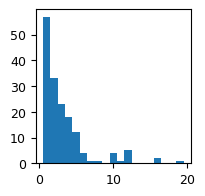

In [421]:
fig, ax = plt.subplots(figsize=(2,2))


# ax.scatter(event_durations, max_sizes, s=30, facecolor='None', edgecolor='k', )

# plt.semilogy()

x = event_durations
y = max_sizes

# Define bins
x_bins = np.arange(0.5, 20.5, 1)       # 29 bins for x
y_bins = np.logspace(1, np.log10(y.max()), 30)#np.linspace(0, 27000, 50)       # 49 bins for y

# 2D histogram
out = plt.hist(x,bins=x_bins)  # You can adjust bins or colormap

# plotter.add_colorbar(fig, ax, [out])


# ax.scatter(x[(start_flag==False)&(final_flag==False)], 
#            y[(start_flag==False)&(final_flag==False)], s=20, facecolor='None', edgecolor=[0.]*3, )

# ax.scatter(x[all_seqs==150], y[all_seqs==150], marker='*', c='k')


# ax.axhline(39, c='gray', ls='dashed')
# ax.text(20,32, 'ASI SIC resolution  ', c='gray', ha='right', va='top')



# X =21
# ax.plot([X,X], [np.nanpercentile(y, 5), np.nanpercentile(y, 95)],  clip_on=False)
# ax.plot([X,X], [np.nanpercentile(y, 25), np.nanpercentile(y, 75)],  lw=5, clip_on=False)
# ax.plot([X,X], [np.nanpercentile(y, 25), np.nanpercentile(y, 50)], lw=5, clip_on=False)
# ax.plot([X,X], [np.nanpercentile(y, 5), np.nanpercentile(y, 25)], lw=5, clip_on=False)


# for per in [2,25,50,75,95]:
#     ax.text(np.nanpercentile(x, per), Y, f'{per}%',clip_on=False)

In [366]:
per

95

In [352]:
Lvals = list(set(event_durations))
data = [y[x==L] for L in Lvals]


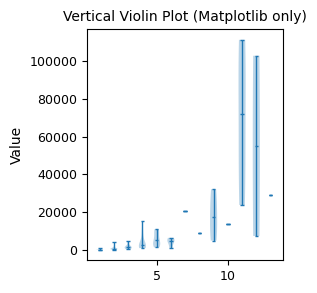

In [349]:
import matplotlib.pyplot as plt
import numpy as np

# Combine data into a list of arrays
# data = [data1, data2, data3]

data = [y[x==L] for L in list(set(event_durations))]

# Create the violin plot
fig, ax = plt.subplots(figsize=(3,3))
parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

# Customize appearance
# ax.set_xticks([1, 2, 3])
# ax.set_xticklabels(['Group A', 'Group B', 'Group C'])
ax.set_ylabel('Value')
ax.set_title('Vertical Violin Plot (Matplotlib only)')

plt.tight_layout()
plt.show()


In [322]:
all_seqs[final_flag==True]

array([ 21,  87, 107])

In [277]:
all_seqs[np.argmax(event_sizes)]

87

In [324]:
event_sizes[all_seqs==107]

array([467.69626171])

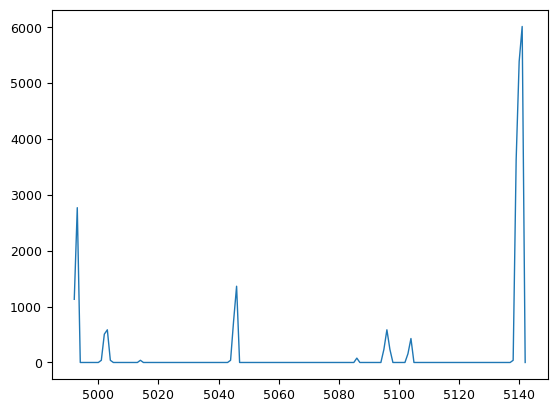

In [327]:
plt.plot(dfr.extent[dfr.year==2021])

In [325]:
dfr.time[dfr.sequence==107]

4688    2018-04-30
Name: time, dtype: object

In [275]:
event_sizes.max()

111361.7626670447

In [276]:
event_sizes[all_seqs==150]

array([102928.22815122])

In [248]:
np.log10(30000)

4.477121254719663

In [ ]:
ax.scatter(x[all_seqs==150], y[all_seqs==150])

In [240]:
y[all_seqs==150]

array([], shape=(0, 162), dtype=float64)

In [197]:
# fig, ax = plt.subplots(figsize=(3,3))
# plt.hist((dfr.length_145max-dfr.length_145min)[dfr.sequence!=-999], bins=np.arange(0,400,10), alpha=0.5)
# plt.hist(dfr.width[dfr.sequence!=-999], bins=np.arange(0,400,10), alpha=0.5)

# fig, ax = plt.subplots(figsize=(3,3))
# plt.scatter(dfr.width[dfr.sequence!=-999], (dfr.length_145max-dfr.length_145min)[dfr.sequence!=-999])

In [128]:
event_sizes.max()

9280.146888920392

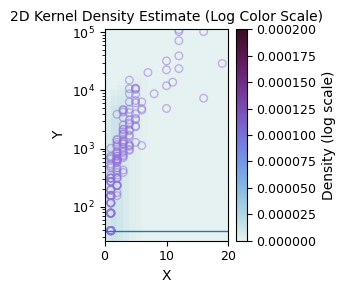

In [184]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm

# --- Generate 2D sample data ---
x = event_durations
y = event_sizes

# --- Perform 2D KDE ---
values = np.vstack([x, y])
kde = gaussian_kde(values)

# Create grid over data range
x_grid = np.arange(0.5,20.5,1)
y_grid = np.linspace(y.min(), y.max(), 50)

X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])

# Evaluate KDE on grid
Z = kde(positions).reshape(X.shape)

# --- Plot using log-scaled colormap ---
fig, ax = plt.subplots(figsize=(3,3))
# cf = ax.contourf(X, Y, Z, levels=50, norm=LogNorm(), cmap='viridis')

cf = ax.pcolormesh(X, Y, Z, cmap=cmocean.cm.dense, vmin=0, vmax=0.0002)

ax.semilogy()

ax.scatter(event_durations, event_sizes, s=30, facecolor='None', edgecolor='mediumpurple', alpha=0.5 )


# Add colorbar
cbar = plt.colorbar(cf, ax=ax)
cbar.set_label('Density (log scale)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('2D Kernel Density Estimate (Log Color Scale)')

plt.axhline(39)

plt.tight_layout()
plt.show()

In [180]:
dfr.event_length[dfr.sequence==150]

5478    16
5479    16
5480    16
5481    16
5482    16
5483    16
5484    16
5485    16
5486    16
5487    16
5488    16
5489    16
5490    16
5491    16
5492    16
5493    16
Name: event_length, dtype: int64

In [179]:
dfr.time[dfr.sequence==150]

5478    2024-01-03
5479    2024-01-04
5480    2024-01-05
5481    2024-01-06
5482    2024-01-07
5483    2024-01-08
5484    2024-01-09
5485    2024-01-10
5486    2024-01-11
5487    2024-01-12
5488    2024-01-13
5489    2024-01-14
5490    2024-01-15
5491    2024-01-16
5492    2024-01-17
5493    2024-01-18
Name: time, dtype: object

(array([92., 22.,  9.,  6.,  8.,  0.,  4.,  1.,  3.,  0.,  4.,  0.,  1.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000., 11000., 12000., 13000., 14000., 15000.,
        16000., 17000., 18000., 19000., 20000., 21000., 22000., 23000.,
        24000., 25000., 26000., 27000., 28000., 29000.]),
 <BarContainer object of 29 artists>)

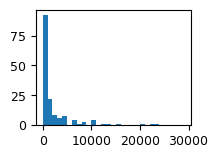

In [101]:
fig, ax = plt.subplots(figsize=(2,1.5))
plt.hist(event_sizes, bins=np.arange(0,30000,1000))

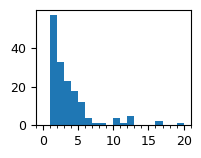

In [91]:
fig, ax = plt.subplots(figsize=(2,1.5))
plt.hist(event_durations, bins=np.arange(0,21,1))

ax.set_ylim(0,)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

(array([16.,  0.,  4., 16.,  2.,  0.,  6.,  3.,  0.,  4.]),
 array([38.95349509, 38.95791057, 38.96232605, 38.96674153, 38.97115701,
        38.97557249, 38.97998798, 38.98440346, 38.98881894, 38.99323442,
        38.9976499 ]),
 <BarContainer object of 10 artists>)

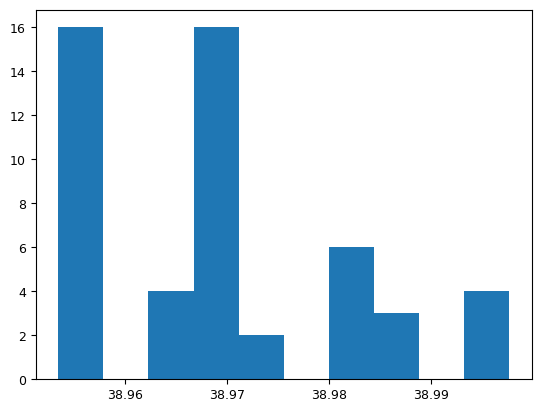

In [92]:
plt.hist(dfr.extent[(dfr.extent<50)&(dfr.sequence!=-999)])

<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_59413/1893579119.py:46: SyntaxWarning: invalid escape sequence '\m'
  cb_label='Open extent $\mathrm{(km^2)}$', labelpad='auto',
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_59413/1893579119.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


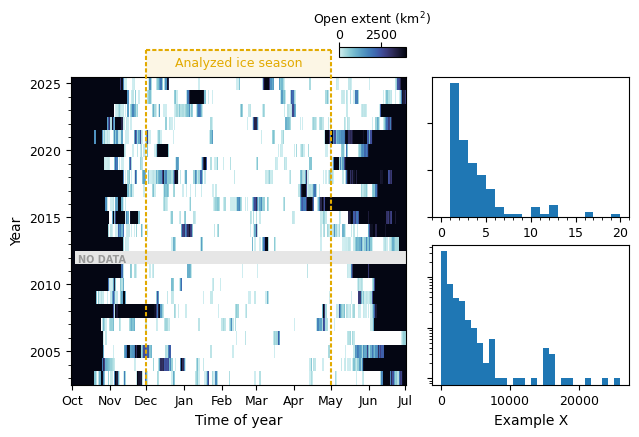

In [87]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FixedLocator
from matplotlib.gridspec import GridSpec
from datetime import timedelta
import cmocean

# --- Create figure and GridSpec layout ---
fig = plt.figure(figsize=(7.2, 4))  # wider to fit extra plots
gs = GridSpec(nrows=2, ncols=2, width_ratios=[1.7, 1], height_ratios=[1, 1], wspace=0.1)

# === Left panel: original plot ===
ax = fig.add_subplot(gs[:, 0])
ax.set_facecolor([0.9, 0.9, 0.9])

# --- Modify colormap ---
cmap = cmocean.tools.crop_by_percent(cmocean.cm.ice_r, 5, which='min')
colors = cmap(np.arange(cmap.N))
colors[0] = [1, 1, 1, 1]  # Replace first color with white
modified_cmap = ListedColormap(colors)

# --- Pcolormesh plot ---
mesh = ax.pcolormesh(ds.time, years, extents, vmin=0, vmax=4000, cmap=modified_cmap)

# --- Customize x-axis ---
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xlabel('Time of year')

# --- Customize y-axis ---
ax.set_ylabel('Year')
ax.set_ylim(years.min() - 0.5, years.max() + 0.5)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

# --- Colorbar ---
plotter.add_colorbar(
    fig, ax, [mesh],
    cb_placement='top', cb_orientation='auto',
    cb_width=0.025, cb_length_fraction=[0.8, 1], cb_pad=0.05,
    cb_ticks='auto', cb_ticklabels='auto', cb_extend='neither',
    cb_label='Open extent $\mathrm{(km^2)}$', labelpad='auto',
    cb_label_placement='auto', cb_tick_placement='auto',
    tick_kwargs={'pad': 0.1}, cb_labelsize=plt.rcParams['font.size'],
    draw_edges=False, edge_params=['k', 2]
)

# --- Ice season highlight rectangle ---
top_y = years.max() + 0.5
height = 2
is_color = [226/255, 170/255, 0/255]

rect = Rectangle(
    (tD, top_y), tMa - tD, height,
    facecolor=is_color, edgecolor='None',
    alpha=0.1, linewidth=1.25, clip_on=False
)
ax.add_patch(rect)

# --- Labels and annotations ---
ax.text(tO + timedelta(days=5), 2012 - 0.1, 'NO DATA', ha='left', va='center',
        c=[0.6]*3, weight='bold', size=plt.rcParams['font.size'] - 2)
ax.text(0.5, 1.045, 'Analyzed ice season', transform=ax.transAxes,
        ha='center', va='center', c=is_color)

# --- Bounding lines ---
line_kwargs = dict(color=is_color, lw=1.5, linestyle='solid', clip_on=False, zorder=100)
dashed_kwargs = {**line_kwargs, 'dashes': (2, 1)}

ax.plot([tD, tD], [2003 - 0.5, top_y + height], **dashed_kwargs)
ax.plot([tMa, tMa], [2003 - 0.5, top_y + height], **dashed_kwargs)
ax.plot([tD, tMa], [top_y + height, top_y + height], **dashed_kwargs)

# === Right panel: Top subplot ===
ax_top = fig.add_subplot(gs[0, 1])
ax_top.hist(event_durations, bins=np.arange(0,21,1))

# ax_top.set_ylim(0,)
ax_top.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax_top.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax_top.tick_params(labelleft=False)

# === Right panel: Bottom subplot ===
ax_bottom = fig.add_subplot(gs[1, 1])
ax_bottom.hist(dfr.extent[dfr.extent>0], bins=30, log=True)
ax_bottom.set_xlabel('Example X')
ax_bottom.tick_params(labelleft=False)

plt.tight_layout()
plt.show()


<BarContainer object of 51 artists>

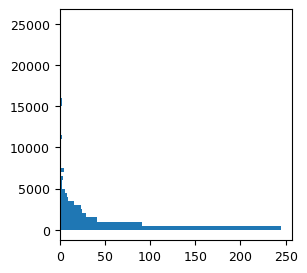

In [99]:
fig,ax = plt.subplots(figsize=(3,3))

ret = plotter.quick_hist(dfr.extent[dfr.extent>0], bin_edges=np.arange(0,26000,500))
ax.barh(ret['centers'], ret['counts'], height=ret['w'])
# plt.hist(dfr.extent[dfr.extent>0], bins=30, log=True)

In [ ]:
### Old version

In [60]:
fig, ax = plt.subplots(figsize=(6,3.25))


years2 = np.arange(2003,2026)

all_YY = []

sizes_over_time = np.array([])


for yy, year in enumerate(years2):
    
    YY = yy * 4
    all_YY.append(YY)
    
    
    if year == 2012:
        sizes_over_time = np.append(sizes_over_time, np.full(274, np.nan))
        
    else:
    
        # open polynya data and crop to time range
        #-----------------------------------------
        DSo = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v6.nc')
        time_range = slice(datetime(year-1,10,1), datetime(year,1,1,0) + timedelta(days=119+62))
        DSo = DSo.sel(time = time_range)

        # find first and last closure dates
        dt_og = (pd.to_datetime(DSo.time.values) - datetime(year,1,1)).days
        water_area = (DSo.polynya_extent + DSo.other_polynya_extent)/1000

        # first/last day of compact conditions
        closure_ind = np.where(water_area == 0)[0][0]
        breakup_ind = np.where(water_area == 0)[0][-1]

        # re-define dt
    #     dt = (pd.to_datetime(DS.time.values) - datetime(year,1,1)).days
        # plot polynya data
    #     ax.bar(dt_og, DSo.polynya_extent/1000, bottom=YY, color='lightgray', alpha=0.5)

        tim = pd.to_datetime(np.array([datetime(2025,1,1) + timedelta(days=dd) for dd in dt_og]))
        if year%4 == 0:
            tim_i = tim
        ext = water_area

        
        if len(ext) < 274:
            sizes_over_time = np.append(sizes_over_time, np.append(ext, np.full(274 -len(ext), np.nan)))
        else:
            sizes_over_time = np.append(sizes_over_time, ext)
                                        
        ext, _ = tseries.linear_interpolate(tim, tim, ext, max_dt = 7 * units('day'))

    #     ax.plot(tim, YY+ext, color=colors['blue3'], alpha=0.5, lw=0.5, zorder=yy)
    
#         plot_color = [0.3,0.3,0.3]
        plot_color = 'dodgerblue'
        ax.fill_between(tim, YY, YY+ext, color=plot_color, lw=0, alpha=0.5, zorder=2*yy)
        ax.plot(tim, YY+ext, color=plot_color, lw=0.75, alpha=1, zorder=2*yy)
        
        
#         ax.bar(tim, ext, bottom=YY, color=plot_color, lw=0, alpha=0.65, width=tim[1]-tim[0], zorder=yy)
        
        sc = 'k'
        ax.scatter(tim[closure_ind], YY, marker='*', color=sc, s=20, zorder=1000)
        
        if year!=2025:
            ax.scatter(tim[breakup_ind], YY, marker='*', color=sc, s=20, zorder=1000)

    

        # re-define dt
        closure_ind = np.where(pd.to_datetime(DSo.time.values) == datetime(year-1,12,1))[0][0]
        breakup_ind = np.where(pd.to_datetime(DSo.time.values) == datetime(year,4,30))[0][0]
        DS = DSo.sel(time = slice(DSo.time[closure_ind],DSo.time[breakup_ind]))
        dt = (pd.to_datetime(DS.time.values) - datetime(year,1,1)).days
        ext = DS.polynya_extent.values/1000
        tim = np.array([datetime(2025,1,1) + timedelta(days=dd) for dd in dt])

        ext, _ = tseries.linear_interpolate(tim, tim, ext, max_dt = 3 * units('day'))
        
        ec = 'orange'
        for st in tim[ext>0]:
            ax.plot([st, st+timedelta(hours=25)], [YY-1,YY-1], 
                       color=ec, lw=1.5, alpha=1, zorder=-1)

    
    if year%5 ==0:
        color1 = [0.3,0.3,0.3]
        ax.text(datetime(2024,10,10), YY, year, va='center', ha='right', clip_on=False)
        ax.plot([datetime(2024,10,11),datetime(2024,10,15)], [YY,YY], c=color1, lw=0.5, zorder=100, clip_on=False)
        ax.plot([datetime(2025,6,15),datetime(2025,7,25)], [YY,YY],  c=color1, lw=0.5, zorder=100, clip_on=False)
        ax.axhline(YY, c=color1, lw=0.5, zorder=100)
        
    else:
        color2 = [0.3,0.3,0.3]
        ax.plot([datetime(2024,10,13),datetime(2024,10,15)], [YY,YY], 
            c=color2, lw=0.5, zorder=100, clip_on=False)
        ax.plot([datetime(2025,6,15),datetime(2025,7,25)], [YY,YY], 
            c=color2, lw=0.5, zorder=100, clip_on=False)
        ax.axhline(YY, c=color2, lw=0.5, zorder=100)#-100)
    
ax.set_ylim(-4,YY+15)
    
ax.set_yticks([])

# xvals = [-61,-31,0,30,58,89,119,150]
# ticklabs = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
# for tt, lab in zip(xvals, ticklabs):
#     ax.text(tt, -26, f'1 {lab}', ha='center')


ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Display month abbreviations
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=[15,]))

ax.set_xlim(datetime(2024,10,15),datetime(2025,6,15))
    
ax.set_xlabel('Day of year')

    
all_YY = np.array(all_YY)

# label SIC record
date1 = datetime(2025,6,23)
date2 = datetime(2025,7,2)
date3 = datetime(2025,7,11)
date4 = datetime(2025,7,19)

line_kwargs = {'clip_on':False, 'lw':5, 'color': [0.3,0.3,0.3], 'zorder':1000}
dot_kwargs = {'clip_on':False, 'marker':'o', 's':15, 'c':line_kwargs['color'], 'zorder':1000}
x_kwargs = {'clip_on':False, 'marker':'x', 's':30, 'c':line_kwargs['color'], 'zorder':1000}

# draw lines
for date, pair in zip([date1, date1, date2, date3, date4],
                      ([2003, 2011], [2013, 2025], [2003, 2025], [2003, 2023], [2017, 2019])):
#     ax.plot([date, date], [all_YY[years2==pair[0]], all_YY[years2==pair[1]]], **line_kwargs)

    ax.plot([date, date], [all_YY[years2==pair[0]], all_YY[years2==pair[1]]], **line_kwargs)

# draw markers on their own
# for date, year, kwarg in zip([date1, date1, date1, date2, date3, date4, date4],
#                              [2003, 2025, 2012,2025, 2023, 2017, 2019], 
#                              [dot_kwargs, dot_kwargs, x_kwargs,dot_kwargs,
#                               dot_kwargs,dot_kwargs,dot_kwargs]):
#     ax.scatter([date], all_YY[years2==year], **kwarg)
    
# arrow markers
ax.scatter([date2], all_YY[years2==2003]-1.5, marker='v', s=100, c=line_kwargs['color'], clip_on=False, zorder=10000)
ax.scatter([date3], all_YY[years2==2003]-1.5, marker='v', s=100, c=line_kwargs['color'], clip_on=False, zorder=10000)

    
# text labels
for date, year, label in zip([date1, date2, date3, date4],
                             [2025, 2025, 2023, 2019],
                             ['  ASI SIC', '  ERA5', '  PP ice drift', "  MARES moorings"]):
    ax.text(date, all_YY[years2==year], label, ha='center',weight='bold', va='bottom',c=[0.3,0.3,0.3], rotation=90)



ax.scatter(tim[-70], all_YY.max()+20, marker='*', color=sc, s=20, clip_on=False, zorder=1000)
ax.text(tim[-70], all_YY.max()+20, '  First and last complete ice', ha='left', va='center', clip_on=False, zorder=1000)


st = tim[-72]
ax.plot([st, st+timedelta(hours=72)], [YY+30,YY+30], 
                       color=ec, lw=1.5, alpha=1, clip_on=False, zorder=1000)
ax.text(tim[-70], all_YY.max()+30, '  Analyzed polynya events', ha='left', va='center', clip_on=False, zorder=1000)


date = datetime(2024,11,1)
db = timedelta(hours=30)
ax.plot([date, date], [all_YY.max()+20, all_YY.max()+30], lw=1,c='k',  clip_on=False)
ax.plot([date-db, date+db], [all_YY.max()+20, all_YY.max()+20], lw=1,c='k',  clip_on=False)
ax.plot([date-db, date+db], [all_YY.max()+30, all_YY.max()+30], lw=1,c='k',  clip_on=False)
ax.text(date+2*db, all_YY.max()+25, '$\mathrm{10^4\;km^2}$ polynya extent', 
        ha='left', va='center', clip_on=False, zorder=1000)


# color=[0.6,0.6,0.6]
# ax.plot([datetime(2024,12,4), datetime(2025,4,29)], 
#         [all_YY.max()+25, all_YY.max()+25], lw=7, c=color, clip_on=False)
# for date in [datetime(2024,12,1), datetime(2025,4,30)]:
#     ax.plot([date,date], [all_YY.min()-3, all_YY.max()+25], 
#             lw=2, ls='solid', alpha=0.5, c=color, clip_on=False)


ax.set_ylabel('Year', labelpad=40)

# fig.savefig('../figures/results/identified_events_v2.png', dpi=400, bbox_inches='tight', pad_inches=0)


time_grid, year_grid = np.meshgrid(tim_i, years2)
sizes_over_time = np.reshape(sizes_over_time, (len(years2), int(len(sizes_over_time)/len(years2))))

AttributeError: module 'cmocean.cm' has no attribute 'get_cmap'